In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
from shutil import copyfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from scipy import ceil
import scipy

In [3]:
source_path = '/content/drive/MyDrive/Data set FIX2'


list=[]

for i in os.listdir(source_path):
    source_path_item = os.path.join(source_path, i)
    n = 0
    for j in os.listdir(source_path_item):
        if j[-3:] == "jpg" or j[-3:] == "gif":
            im = Image.open(os.path.join(source_path_item, j)).convert("RGB")
            im.save(os.path.join(source_path_item, j[:-3]+'jpeg'))

            os.remove(os.path.join(source_path_item, j))
            n += 1

    print("Convert Successful")
    print("Converted image =",n)
    print(f"There are {len(os.listdir(source_path_item))} images of", i + ".\n")
    list.append(i)

Convert Successful
Converted image = 0
There are 522 images of Ayaka.

Convert Successful
Converted image = 0
There are 403 images of Zoro.

Convert Successful
Converted image = 0
There are 339 images of Killua.

Convert Successful
Converted image = 84
There are 202 images of kurumi.

Convert Successful
Converted image = 54
There are 206 images of asuka.



In [4]:
root_dir = 'Animee'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

for i in list:
    os.makedirs(os.path.join(root_dir,"train",i))
    os.makedirs(os.path.join(root_dir,"validation",i))

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  random_sample=random.sample(os.listdir(SOURCE_DIR),len(os.listdir(SOURCE_DIR)))

  size=int(len(random_sample)*SPLIT_SIZE)

  target=TRAINING_DIR
  i=0

  for item in random_sample:

    item_source = os.path.join(SOURCE_DIR, item)

    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    if i == size:
      target = VALIDATION_DIR

In [6]:
train_dir = os.path.join(root_dir,"train")
val_dir = os.path.join(root_dir,"validation")

for i in os.listdir(train_dir):
  path = os.path.join(train_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

for i in os.listdir(val_dir):
  path = os.path.join(val_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

split_size = .8

for i in list:
  split_data(os.path.join(source_path,i), os.path.join(train_dir, i), os.path.join(val_dir, i), split_size)
  print("Split", i, "Successful")
  print(f"There are {len(os.listdir(os.path.join(train_dir,i)))} images of", i + " for training.")
  print(f"There are {len(os.listdir(os.path.join(val_dir,i)))} images of", i + " for validation.\n")

Split Ayaka Successful
There are 417 images of Ayaka for training.
There are 105 images of Ayaka for validation.

Split Zoro Successful
There are 322 images of Zoro for training.
There are 81 images of Zoro for validation.

Split Killua Successful
There are 271 images of Killua for training.
There are 68 images of Killua for validation.

Split kurumi Successful
There are 161 images of kurumi for training.
There are 41 images of kurumi for validation.

Split asuka Successful
There are 164 images of asuka for training.
There are 42 images of asuka for validation.



In [7]:
TRAINING_DIR = "/content/Animee/train"
TESTING_DIR = "/content/Animee/validation"
#train_val_generators
def train_val_generators(TRAINING_DIR, TESTING_DIR):

  train_data = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_data.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(299,299))

  # Rescaling Image
  testing_data = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  testing_generator = testing_data.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(299,299))
  ### END CODE HERE
  return train_generator, testing_generator

In [8]:
# Check Generator Working or not
train_generator, testing_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 1334 images belonging to 5 classes.
Found 337 images belonging to 5 classes.


In [9]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model

base_model = Xception(weights='imagenet', input_shape = (299,299,3), include_top=False, pooling = 'avg')

  # Flatten
x = base_model.output
  # Add Full connected layer
x = Dense(128, activation='relu')(x)
  # Adding dropout layer to prevent overfit
x = Dropout(rate=.2)(x)
  # ouput layer for 5 categories that we train
predictions = Dense(5, activation='softmax')(x)

  # Training Model
model = Model(inputs=base_model.input, outputs=predictions)

#freeze all trainable layer
for layer in base_model.layers:
  layer.trainable = False

#Compile the model
model.compile(optimizer='adam',
          loss='categorical_crossentropy',
              metrics=['accuracy'])

#unfreeze several layer from trainable layer
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

model.summary();
# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=testing_generator)

83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
42/42 [==============================] - 81s 2s/step - loss: 0.9318 - accuracy: 0.6649 - val_loss: 0.4737 - val_accuracy: 0.8783
Epoch 2/20
42/42 [==============================] - 67s 2s/step - loss: 0.4232 - accuracy: 0.8711 - val_loss: 0.4053 - val_accuracy: 0.8665
Epoch 3/20
42/42 [==============================] - 65s 2s/step - loss: 0.3270 - accuracy: 0.8981 - val_loss: 0.2838 - val_accuracy: 0.9199
Epoch 4/20
42/42 [==============================] - 67s 2s/step - loss: 0.2525 - accuracy: 0.9288 - val_loss: 0.3098 - val_accuracy: 0.8961
Epoch 5/20
42/42 [==============================] - 67s 2s/step - loss: 0.2573 - accuracy: 0.9055 - val_loss: 0.2521 - val_accuracy: 0.9169
Epoch 6/20
42/42 [==============================] - 63s 2s/step - loss: 0.2048 - accuracy: 0.9363 - val_loss: 0.2677 - val_accuracy: 0.9021
Epoch 7/20
42/42 [==============================] - 64s 2s/step - loss: 0.1881 - accuracy: 0.9430 - val_loss: 0.2082 - val_accuracy: 0.9407
Epoch 8/20
42/42 [==

In [10]:
def plot_train_history(history):
    # Summarize history for accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs,loss, 'r', label='train_loss')
    plt.plot(epochs,val_loss, 'b', label='test_loss')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc=0)
    plt.show()



In [13]:
model.save('modelanimefirst.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
model_json = model.to_json()
with open("model_tf_learning_fix.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weight_tf_learning_fix.h5")
print("Saved model to disk")

Saved model to disk


1/1 [==============================] - 0s 80ms/step


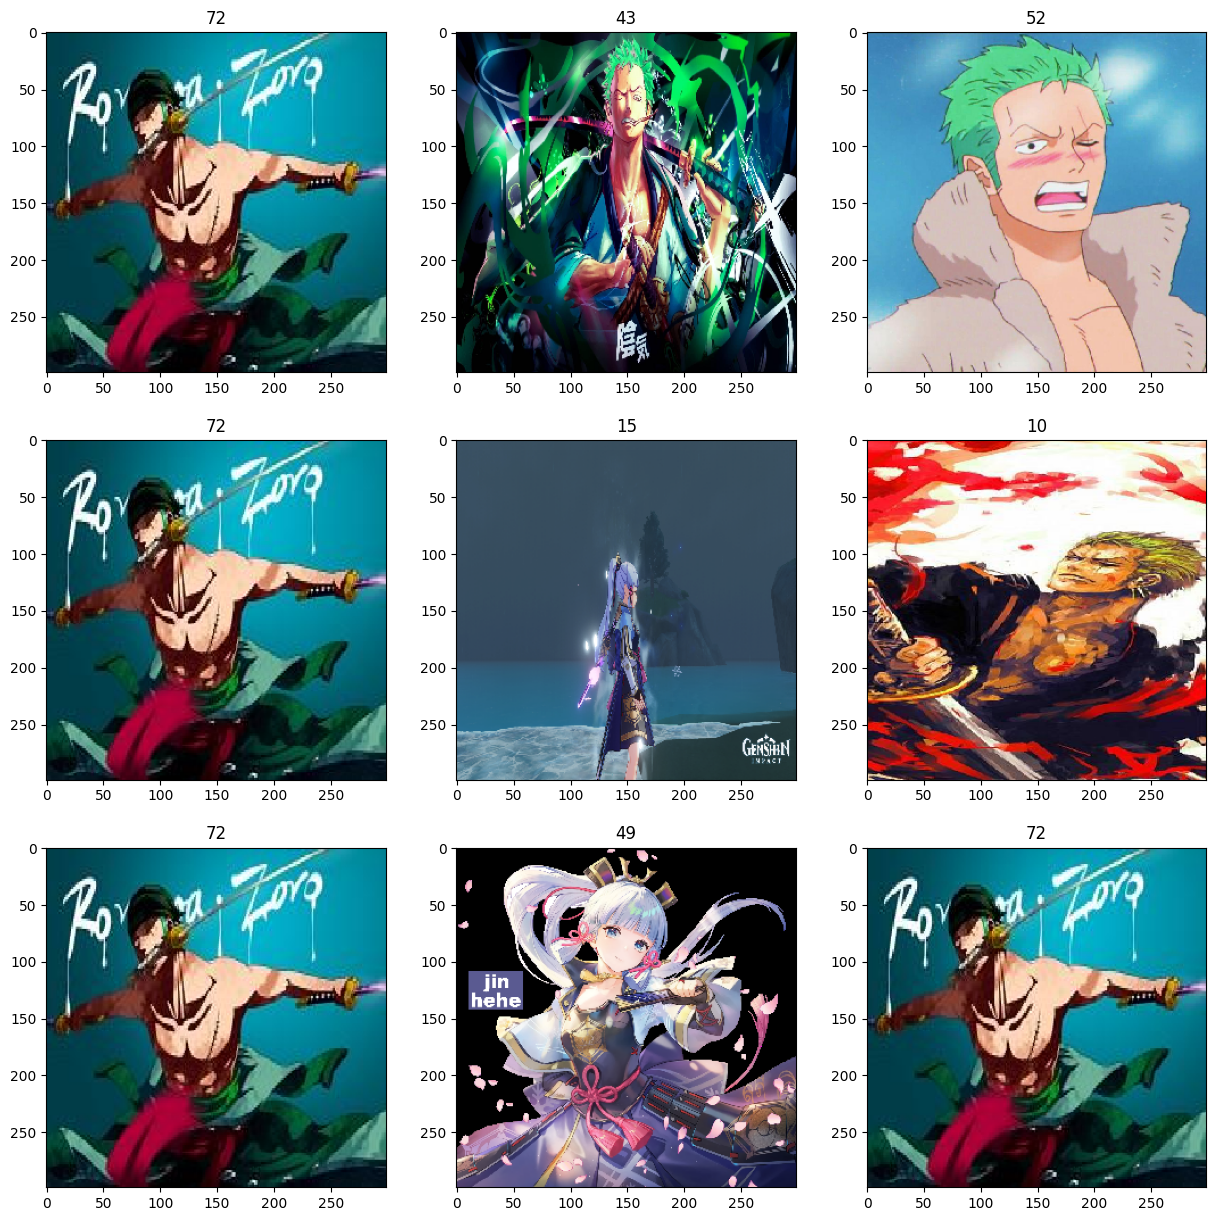

In [11]:
import numpy as np
label_names = {0: 'Ayaka', 1: 'Killua', 2: 'Zoro', 3: 'asuka',4: 'kurumi'}
def run_prediction():
     n = 331
     plt.figure(figsize=(15, 15))
     for i in range(9):
         plt.subplot(n)
         idx = random.randint(0, len(testing_generator)-1)
         predict = model.predict(testing_generator[idx][0])
         plt.imshow(testing_generator[idx][0][0])
         plt.title(np.argmax(predict))
         n += 1
run_prediction()

In [15]:
# load and evaluate a saved model
from keras.models import load_model

# load model
model = load_model('modelanimefirst.h5')

In [16]:
# new_model= tf.keras.models.load_model(model)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with open("model_tflite.tflite", 'wb') as f:
  f.write(tflite_model)
  print("Saved model to disk")

Saved model to disk


In [12]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt


file_paths = [
    '/content/drive/MyDrive/sample/asuka 3.png',
    '/content/drive/MyDrive/sample/asuka 5.png',
    '/content/drive/MyDrive/sample/asuka scene 2.jpg',
    '/content/drive/MyDrive/sample/asuka scene 4.jpg',
    '/content/drive/MyDrive/sample/ayaka sample 1.png',
    '/content/drive/MyDrive/sample/ayaka sample 2.png',
    '/content/drive/MyDrive/sample/ayaka sample 3.jpg',
    '/content/drive/MyDrive/sample/ayaka sample 4.png',
    '/content/drive/MyDrive/sample/kilua1.jpeg',
    '/content/drive/MyDrive/sample/kilua2.jpg',
    '/content/drive/MyDrive/sample/kilua3.jpg' ,
    '/content/drive/MyDrive/sample/kilua4.jpg',
    '/content/drive/MyDrive/sample/kurumi 1.png',
    '/content/drive/MyDrive/sample/kurumi 2.png',
    '/content/drive/MyDrive/sample/kurumi 3.png',
    '/content/drive/MyDrive/sample/kurumi 5.png',
    '/content/drive/MyDrive/sample/zoro 2.png',
    '/content/drive/MyDrive/sample/zoro 3.png',
    '/content/drive/MyDrive/sample/zoro 4.png',
    '/content/drive/MyDrive/sample/zoro.png',

    # Add paths for the remaining 18 photos
    # ...
]
for path in file_paths:
    # Load image and resize
    img = image.load_img(path, target_size=(299, 299))
    # Convert image to array and rescale
    x = image.img_to_array(img) / 255
    # Change shape of the image
    x = np.expand_dims(x, axis=0)

    # Make predictions
    classes = model.predict(x, batch_size=10)

    # Get the predicted class name
    label_names = ["Ayaka", "Killua", "Zoro", "asuka", "kurumi"]
    prediction_name = label_names[np.argmax(classes[0])]

    # Get the confidence percentage
    confidence_percentage = str(np.max(classes))

    # Print the results for each image
    print(f"Prediction for {path}: {prediction_name}")
    print(f"Confidence: {confidence_percentage}\n")

    # Optionally, display the image
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.